<a href="https://colab.research.google.com/github/fionakek/ttpy/blob/main/TT_learn_en.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ttpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 317 kB 4.1 MB/s 
  Created wheel for ttpy: filename=ttpy-1.2.1-cp37-cp37m-linux_x86_64.whl size=2964830 sha256=7d38d00b33c0afc663ae72421024951cb0eac40141501abc75b8f66d79310d9b
  Stored in directory: /root/.cache/pip/wheels/1c/45/02/9593e1923b244554f33e29be39b1413772acac8c8a1ba30596
Successfully built ttpy


In [ ]:
import numpy as np
import tt
from tt.optimize import tt_min
from scipy.optimize import rosen
import matplotlib.pyplot as plt
from tt.cross import rect_cross
from tt.amen import amen_solve

# Vector generation and its printing

In [ ]:
x = tt.xfun(2, 2) #generation of vector [0, 1, 2, 3] in QTT format
print(tt.diag(x).full())

[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 3.]]


# Represent the square root function in QTT format

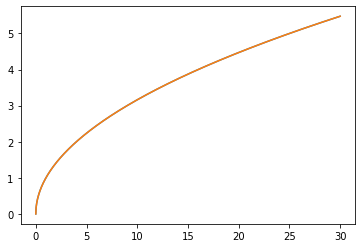

Ranks: [1 2 4 5 5 5 5 5 4 2 1]


In [ ]:
d = 10 #number of QTT-cores
n = 2 ** d #number of discretization points

b = 30 # [0, b] - interval on which we consider the function
h = b / (n - 1) # discretization step

# argument in QTT-format
x = h * tt.xfun(2, d) 

#define the function f
f = lambda x : np.sqrt(x)

#approximation f(x) = sqrt(x) via QTT with tolerance = 1e-6 using tt-cross
y = tt.multifuncrs([x], lambda x: np.sqrt(x) , 1e-6, verb = False) 


#Checking
points = []
correct_points = []
tt_points = []

for i in range(n):
  points.append(i * h)
  correct_points.append(f(i * h))
  tt_points.append(tt.dot(y, tt.delta(2, d = d, center = i )))
  

#Plots are the same
plt.plot(points, correct_points)
plt.plot(points, tt_points)
plt.show()

#print ranks
print('Ranks:', y.r)

# Integrate this function on the interval

$\int_0^b \sqrt{x} dx = (y, e)$

In [ ]:
#unit vector in QTT format
e = tt.ones(2, d) 

#find the integral as scalar product
TT_int = tt.dot(y, e) * h

print('TT_int:',TT_int)
print('Correct value:', b * np.sqrt(b) / 1.5 )

TT_int: 109.62378528388167
Correct value: 109.54451150103323


# Integrate a high-dimensional function

$(2 \pi)^{d / 2} \sqrt{\operatorname{det} C} = \int_{\mathbb{R}^{d}} e^{-(1 / 2) \mathbf{x}^{T} C^{-1} \mathbf{x}} d \mathbf{x} \simeq  \int_{[-a, a]^{d}} e^{-(1 / 2) \mathbf{x}^{T} C^{-1} \mathbf{x}} d \mathbf{x}  $

$C=\left(\begin{array}{ccccc}
1 & 1 & 1 & \cdots & 1 \\
1 & 2 & 2 & \cdots & 2 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & 2 & 3 & \cdots & d
\end{array}\right)$

In [ ]:
def C_matrix(d):
    C = np.zeros((d, d))
    for i in range(d):
        for j in range(d):
            C[i, j] = min(i, j) + 1
    return C

In [ ]:
def tt_gaus_sample(x, C_inv):
  # x is np.array of shape [n_samples, d]
  # this function should return array of function values in all samples, i.e. return size = n_samples 
  return np.exp(np.einsum('ij,jk,ik->i', x, -0.5  * C_inv, x))

In [ ]:
d = 5 #dimension
n = 50 #discretization in one axis
tol = 1e-5 #tollerance
a = 20 #interval size

gridfun = lambda ind: ind*2*a/n - a 

C = C_matrix(d)
C_inv = np.linalg.inv(C)

tt_gaus = rect_cross.cross(lambda arg: tt_gaus_sample(gridfun(arg), C_inv), tt.rand(n, d, r = 10), nswp = 10, eps=tol, kickrank=5, rf=1, verbose= True) 

tt_gaus = tt_gaus.round(tol)
print(tt_gaus.r)

swp: 0/9 er_rel = 5.0e+05 er_abs = 1.7e+06 erank = 20.0 fun_eval: 70500
swp: 1/9 er_rel = 8.6e-01 er_abs = 6.3e+00 erank = 30.2 fun_eval: 264250
swp: 2/9 er_rel = 1.8e-02 er_abs = 1.3e-01 erank = 40.2 fun_eval: 642350
swp: 3/9 er_rel = 6.4e-11 er_abs = 4.7e-10 erank = 50.3 fun_eval: 1263450
[ 1 11 15 19 22  1]


In [ ]:
#integration
h = 2 * a / n # grid step-size
tt_answer = tt.dot(tt_gaus, tt.ones(n, d)) * h**d
correct_answer = (2 * np.pi)**(d/2) * np.sqrt(np.linalg.det(C))
print('tt_answer:', tt_answer)
print('correct_answer:', correct_answer)

tt_answer: 98.95737551847299
correct_answer: 98.95771780477259


# QTT integration

In [ ]:
def qtt_gaus_sample(ind, C_inv):

    nsim = ind.shape[0]

    # Translation from binary to decimal
    ind = np.array(ind, dtype=int)
    lifting_sizes = np.roll(np.repeat(2,q),1)  # vectorised ravel_multi_index
    lifting_sizes[0] = 1  
    lifting_sizes = np.cumprod(lifting_sizes)

    x = np.zeros((nsim, d))
    for i in range(d):
         x[:, i] = np.sum(ind[:,i * q: (i + 1) * q] * lifting_sizes, axis=1) * 2*a / 2**q - a # Global indices in x[i]

    return np.exp(np.einsum('ij,jk,ik->i', x, -0.5  * C_inv, x))

In [ ]:
def qtt_func(ind):

    nsim = ind.shape[0]

    # Translation from binary to decimal
    ind = np.array(ind, dtype=int)
    lifting_sizes = np.roll(np.repeat(2,q),1)  # vectorised ravel_multi_index
    lifting_sizes[0] = 1  
    lifting_sizes = np.cumprod(lifting_sizes)

    x = np.zeros((nsim, 1))
    
    x = np.sum(ind[:,i * q: (i + 1) * q] * lifting_sizes, axis=1) * 2*a / 2**q - a # Global indices in x[i]

    return np.exp(-x**2)

qtt_func = rect_cross.cross(lambda arg: qtt_func(arg, C_inv), # target function
                                          tt.rand(2, d*q), # initial approximation
                                          nswp = 10, # number of sweeps 
                                          eps=tol, # tolerance
                                          kickrank=5, # how the rank is increased during the solution
                                          rf=1, # rank dynamics
                                          verbose= True # Printing the intermediate results
                                         ) 

In [ ]:
d = 5 #dimension
q = 7 # 2**q is the discretization in one axis
tol = 1e-5 #tollerance
a = 20 #interval size

gridfun = lambda ind: ind*2*a/n - a 

C = C_matrix(d)
C_inv = np.linalg.inv(C)

qtt_gaus = rect_cross.cross(lambda arg: qtt_gaus_sample(arg, C_inv), # target function
                                          tt.rand(2, d*q), # initial approximation
                                          nswp = 10, # number of sweeps 
                                          eps=tol, # tolerance
                                          kickrank=5, # how the rank is increased during the solution
                                          rf=1, # rank dynamics
                                          verbose= True # Printing the intermediate results
                                         ) 

qtt_gaus = qtt_gaus.round(tol)
print(qtt_gaus.r)

swp: 0/9 er_rel = 2.0e+12 er_abs = 1.2e+09 erank = 11.4 fun_eval: 5970
swp: 1/9 er_rel = 1.0e+00 er_abs = 3.0e+00 erank = 20.2 fun_eval: 38590
swp: 2/9 er_rel = 1.0e+00 er_abs = 4.3e+01 erank = 29.5 fun_eval: 118458
swp: 3/9 er_rel = 5.1e-01 er_abs = 2.9e+01 erank = 38.8 fun_eval: 270146
swp: 4/9 er_rel = 2.6e-05 er_abs = 1.4e-03 erank = 48.1 fun_eval: 516220
swp: 5/9 er_rel = 2.8e-01 er_abs = 1.7e+01 erank = 57.6 fun_eval: 881260
swp: 6/9 er_rel = 5.4e-01 er_abs = 3.8e+01 erank = 66.7 fun_eval: 1387360
swp: 7/9 er_rel = 4.0e-01 er_abs = 3.1e+01 erank = 75.8 fun_eval: 2052500
swp: 8/9 er_rel = 1.5e-02 er_abs = 1.1e+00 erank = 84.9 fun_eval: 2899240
swp: 9/9 er_rel = 5.5e-07 er_abs = 4.2e-05 erank = 94.0 fun_eval: 3949780
[ 1  2  4  8 14 19 19 15 29 39 36 30 24 24 20 38 48 44 35 28 28 24 46 56
 50 39 32 32 28 28 18 10  6  4  2  1]


In [ ]:
#integration
h = 2 * a / 2**q # grid step-size
qtt_answer = tt.dot(qtt_gaus, tt.ones(2, d*q)) * h**d
correct_answer = (2 * np.pi)**(d/2) * np.sqrt(np.linalg.det(C))
print('qtt_answer:', qtt_answer)
print('correct_answer:', correct_answer)

qtt_answer: 98.95753940710625
correct_answer: 98.95771780477259


# Multidimensional function

$f(x,y,z) = \frac{\sin(x + y)}{(1 + z)}$

In [ ]:
d = 8 
n = 2 ** d #number of discretization points in one axis


b = 1 # [0, b]^3 - domain on which we consider the function
h = b / (n - 1) #step-size

#generation of x
x = h * tt.xfun(2, d) 
e = tt.ones(2, d)

X = tt.mkron(x, e, e)
Y = tt.mkron(e, x, e)
Z = tt.mkron(e, e, x)

#sin(x + y) / (1 + z)
I = tt.multifuncrs([X, Y, Z], lambda arg: np.sin((arg[:,0] + arg[:,1])) / ( 1 + np.exp(arg[:,2]) )  , 1e-6, verb = True) 

I = I.round(1e-6)
print('Ranks', I.r)

=multifuncrs= sweep 1{2}, max_dy: 1.527e+01, erank: 1.95789
=multifuncrs= sweep 2{1}, max_dy: 1.353e-01, erank: 3.59977
=multifuncrs= sweep 2{2}, max_dy: 1.353e-01, erank: 4.8734
=multifuncrs= sweep 3{1}, max_dy: 6.017e-08, erank: 6.01041
=multifuncrs= sweep 3{2}, max_dy: 6.017e-08, erank: 6.09303
=multifuncrs= sweep 4{1}, max_dy: 0.000e+00, erank: 2.11148
Ranks [1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 3 3 3 3 2 1]


# Solution of a linear system of equations

$ u(x)'' = 1$ on interval $[0,1]$ and zero boundary-conditions $u(0) = 0, u(1) = 0$

In [ ]:
#reduce it to the system of linear equations Ax = b 

d = 10 # 2^d - matrix size (discretization of the interval)

A = tt.qlaplace_dd([d]) #creating a matrix in MPO format
b = tt.ones(2, d) #creating right-hand side

y = amen_solve(A,b,b,1e-6) #A, b, initial prediction, accuracy
  
print('error:', (tt.matvec(A, y) - b).norm() / b.norm())

error: 1.716510042201314e-07


# Optimization of function

$f(x, y) = (x - 1)^2 + y^2$

In [ ]:
#define a function to minimize
def square(x):
  #x has shape [number of samples, 2]
  if len(x.shape) > 1:
    res = (x[:, 0] - 1)**2 + x[:, 1]**2 
  else:
    res = (x[0] - 1)**2 + x[1]**2 
  return res

#minimum at point [1, 0]

bounds_min = -2 #lower bound of the interval on which we minimize [-2, 2]
bounds_max = 2 #upper bound of the interval on which we minimize [-2, 2]

d = 2 #dimension of space
n0 = 5 #the number of points taken on each of the axes i.e. [-2, -1, 0, 1, 2]

rmax = 3 #the maximum rank for approximation the function in terms of MPS (the more - the better the minimum, but the running time is scaled as rmax^2)
nswp = 5 #the number of iterations (as in gradient descent)


val, x_full = tt_min.min_func(lambda arg: square(arg), bounds_min = -2, bounds_max = 2, d=2, rmax=5, n0 = 5, nswp=5, verb= False, smooth_fun= None)

print('TT:', x_full, val)
print('correct:', [1, 0], 0)

TT: [1. 0.] 0.0
correct: [1, 0] 0


In [ ]:
#minimizing the Rosenbrock function
#the correct answer is all ones

def my_rosen(x):  
  return rosen(x.T) 

def my_fun(f, x):
  if(len(x.shape) == 1):
    return f(x)
  return np.array([f(i) for i in x])

#minimization on the interval [-5, 5]
bounds_min = -5
bounds_max = 5

#10 variables
d = 10

# rank
rmax=10

#the number of sampling points on each of the axes
n0 = 11
#number of iterations
nswp= 5

val, x_full = tt_min.min_func(fun = lambda x: my_fun(my_rosen, x), bounds_min = -5, bounds_max = 5, d = 10, rmax=10, n0 = 11, nswp= 5, verb= False, smooth_fun= None)
print(x_full, val)

print('correct answer is [1 1 ... 1] and value is 0')

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 0.0
correct answer is [1 1 ... 1] and value is 0


# Find ranks of a tensor

In [ ]:
n = 20
d = 3
tol = 1e-6
A = np.random.normal(size = [n] * d)

print(A.shape)

(20, 20, 20)


In [ ]:
abc = [1, 2, 3]
print(A[tuple(abc)])
print(A[1, 2, 3])

-2.1822811627918113
-2.1822811627918113


In [ ]:
def tt_sample(ind, A):
  ind = np.array(ind, dtype=int)
  N = ind.shape[0]

  Q = np.zeros(N)
  for i in np.arange(N):
   # print(ind[i])
    Q[i] = A[tuple(ind[i])]
  print(Q)
  return Q

In [ ]:
from tt.cross import rect_cross

tt_format = rect_cross.cross(lambda arg: tt_sample(arg, A), tt.rand(n, d), eps=tol, kickrank=1, rf=1, verbose= True)

print(tt_format.r)

swp: 0/9 er_rel = 5.2e+00 er_abs = 1.7e+02 erank = 4.5 fun_eval: 660
swp: 1/9 er_rel = 9.9e-01 er_abs = 5.0e+01 erank = 7.9 fun_eval: 2560
swp: 2/9 er_rel = 1.1e+00 er_abs = 7.4e+01 erank = 11.4 fun_eval: 6860
swp: 3/9 er_rel = 9.4e-01 er_abs = 7.9e+01 erank = 15.4 fun_eval: 15140
swp: 4/9 er_rel = 9.0e-01 er_abs = 8.0e+01 erank = 19.0 fun_eval: 28380
swp: 5/9 er_rel = 6.1e-01 er_abs = 5.4e+01 erank = 20.5 fun_eval: 45240
swp: 6/9 er_rel = 2.6e-01 er_abs = 2.4e+01 erank = 21.0 fun_eval: 62980
swp: 7/9 er_rel = 7.1e-16 er_abs = 6.3e-14 erank = 21.0 fun_eval: 80740
[ 1 22 20  1]
